In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
bus = pd.read_csv('~/Downloads/arrival_times.csv')
bus = bus.dropna(axis=0, how='any')

# combine date and time into a single timestamp
bus['scheduled'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['SCH_STOP_TM'])
bus['actual'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (bus['actual'] - bus['scheduled']) / hour
bus.loc[diff_hrs > 20, 'actual'] -= 24 * hour
bus.loc[diff_hrs < -20, 'actual'] += 24 * hour
bus['minutes_late'] = (bus['actual'] - bus['scheduled']) / minute

bus['route'] = bus['RTE'].replace({673: 'C', 674: 'D', 675: 'E'})
bus['direction'] = bus['DIR'].replace({'N': 'northbound', 'S': 'southbound'})

bus = bus[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

# Exploring Bus Times

We learned a lot about the data as we cleaned and simplified it, but before we begin to model wait time, we want to dig deeper to better understand the phenomena of bus lateness. We have narrowed our focus to the bus activity at one stop (Third Avenue and Pike Street) over a two-month period. Ans, we saw that the distribution of the minutes a bus is late is skewed to the right with some buses being very late indeed. But, we might wonder:

+ Does the distribution of lateness look the same for all three bus lines?
+ Does it matter whether the bus is traveling north or south?
+ How does the time of day relate to how late the bus is?
+ Are the buses scheduled to arrive every 10 or 15 minutes throughout the day? 

Answering these questions helps us better determine how to model. For example, we say in Chapter 4, that when we narrowed down to the northbound C line, then the median time a bus was late was 3/4 of a minute, which doesn't match the median we calculated for all bus routes and directions (1/2 a minute).

Let's begin with the first two questions, and look at histograms of lateness for each of the six combinations of bus line and direction.  

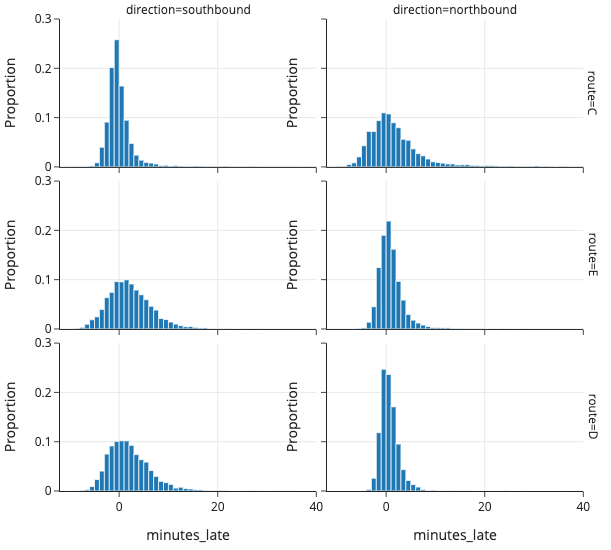

In [3]:
fig = px.histogram(bus, x='minutes_late',
                   histnorm='probability density',
                   nbins = 200,
                facet_row='route', facet_col='direction',
                width=550, height=550)

fig.update_xaxes(range=[-12, 40])
fig.update_yaxes(range=[0, 0.3], 
                 title="Proportion")

fig.show()

The scale on the $ y $-axis is proportion (or density); using proportions makes it easier to compare the histograms. We are not misled by different counts in the groups. The range on the $ x $-axis is the same across the six plots making it easier to detect changes in location and spread of the distributions. (These notions are described in Chapter 11.)

The northbound and southbound distributions are different for each line. It to happens that line C originates in the north and the other two lines originate in the south, which implies that buses tend to greater variability in their schedule toward the end of their route.

Next we look at box plots of how late a bus is by the time of day. To do this, we need to derive a new feature, which we call `hour_of_day`. Given the variation in route and direction, we  again create separate plots for each route and direction. 

In [4]:
bus['hour_of_day'] = bus['scheduled'].dt.hour

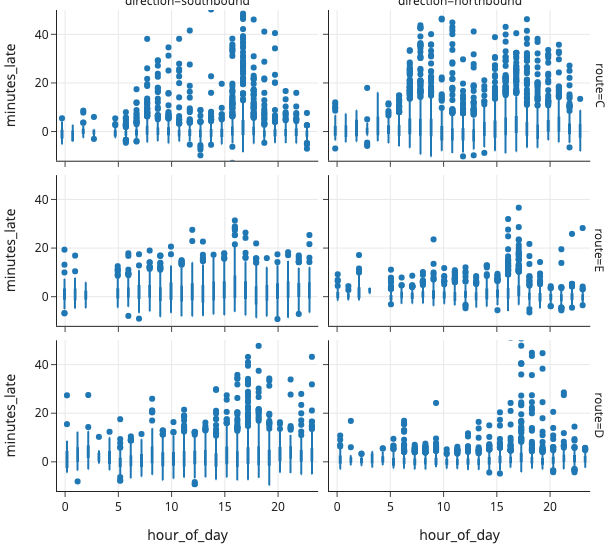

In [5]:
fig = px.box(bus, y='minutes_late', x='hour_of_day',                 
             facet_row='route', facet_col='direction',
             width=550, height=550)

fig.update_yaxes(range=[-12, 50])

fig.show()

Indeed, there does appear to be a rush-hour effect, which appears worse for the evening rush hour compared to the morning. The northbound C line appears the most impacted. Given all of these differences, let's continue to narrow our focus for modeling to buses traveling northbound on the C line. 

In [6]:
bus_c_n = bus[(bus['route'] == 'C') &
                 (bus['direction'] == 'northbound')].copy()

Lastly, to examine the scheduled frequency of the buses, we need to compute the intervals between scheduled bus times. We create a new feature, called 'sched_interval' that contain the time between the a buses scheduled time and the bus before it.

In [7]:
bus_c_n = bus_c_n.sort_values('scheduled')

minute = np.timedelta64(1, 'm')
bus_c_n['sched_inter'] = bus_c_n['scheduled'].diff() / minute

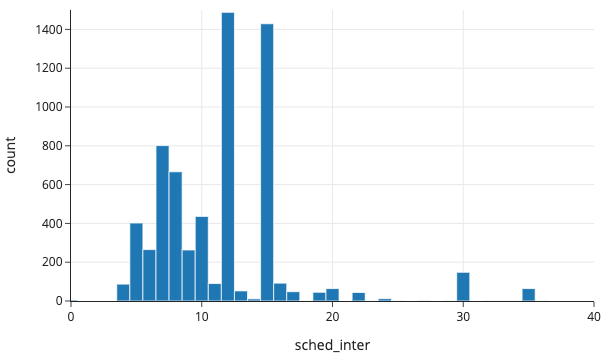

In [8]:
fig = px.histogram(bus_c_n, x='sched_inter', 
                   width=550, height=350)


fig.update_xaxes(range=[0, 40])
fig.update_yaxes(range=[0, 1500])

fig.show()

We see that the buses on line C are not scheduled to arrive at the same interval throughout the day. In this two month period, about 1488 of the buses are scheduled to arrive 12 minutes and another 1424 are supposed to arrive 15 minutes after the previous bus. If we are to model how long we need to wait for a bus, then we must take into account the scheduled interval between buses. 